In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


## 1. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier, early_stopping
from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
import gc

import optuna
from optuna.samplers import TPESampler
import shap

## 2. Load Datasets

In [3]:
train_s = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv').drop("id",axis=1)
test_s = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv').drop("id",axis=1)
original = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

## 3. EDA

In [4]:
dfs = [train_s, test_s, original]

print(f"Train shape : {train_s.shape}")
print(f"Test shape : {test_s.shape}")
print(f"Original shape : {original.shape}")

for df in dfs:
    print(df.info())

Train shape : (58645, 12)
Test shape : (39098, 11)
Original shape : (32581, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float

In [5]:
train_s.describe(include=['int','float'])

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


In [6]:
train_s.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,58645,58645,58645,58645
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,30594,12271,20984,49943


In [7]:
test_s.describe(include=['int','float'])

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
count,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000
mean,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707
std,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157
min,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000
25%,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000
50%,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000
75%,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000
max,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000


In [8]:
test_s.describe(include='object')

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
count,39098,39098,39098,39098
unique,4,6,7,2
top,RENT,EDUCATION,A,N
freq,20280,8076,14005,33227


### 3.1 Original data - Train data

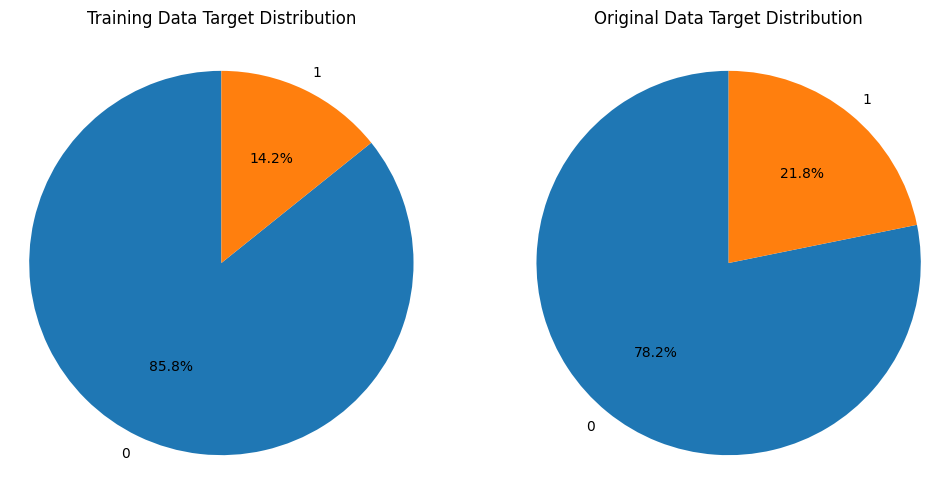

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

train_distribution = train_s['loan_status'].value_counts()
axs[0].pie(train_distribution, labels=train_distribution.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Training Data Target Distribution')
axs[0].axis('equal')

orig_distribution = original['loan_status'].value_counts()
axs[1].pie(orig_distribution, labels=orig_distribution.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Original Data Target Distribution')
axs[1].axis('equal')

plt.show()

Target distribution seems different across datasets. Need to check if difference is significant.

In [10]:
# Check adversarial validation
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score

train_s['label'] = 0
original['label'] = 1
adval_df = pd.concat([train_s, original], axis=0, ignore_index=True)

adval_df['person_emp_length'] = adval_df['person_emp_length'].fillna(original['person_emp_length'].mean())
adval_df['loan_int_rate'] = adval_df['loan_int_rate'].fillna(original['loan_int_rate'].mean())

cat_cols = list(set([col for col in adval_df.columns if adval_df[col].dtype == object]))

for cat_col in cat_cols:
    adval_df[cat_col] = adval_df[cat_col].fillna("nan").astype(str).astype("category")
    
cross_val_score(
    LGBMClassifier(n_estimators=1, verbosity=-1),
    adval_df,
    adval_df['label'],
    scoring="roc_auc_ovr",
    cv = 5)

array([1., 1., 1., 1., 1.])

#### This result shows that our model easily detects which dataset the point comes from. This means train and original dataset has significant differences. Concatting two dataset might affect model performance.

### Avg target for categorical columns

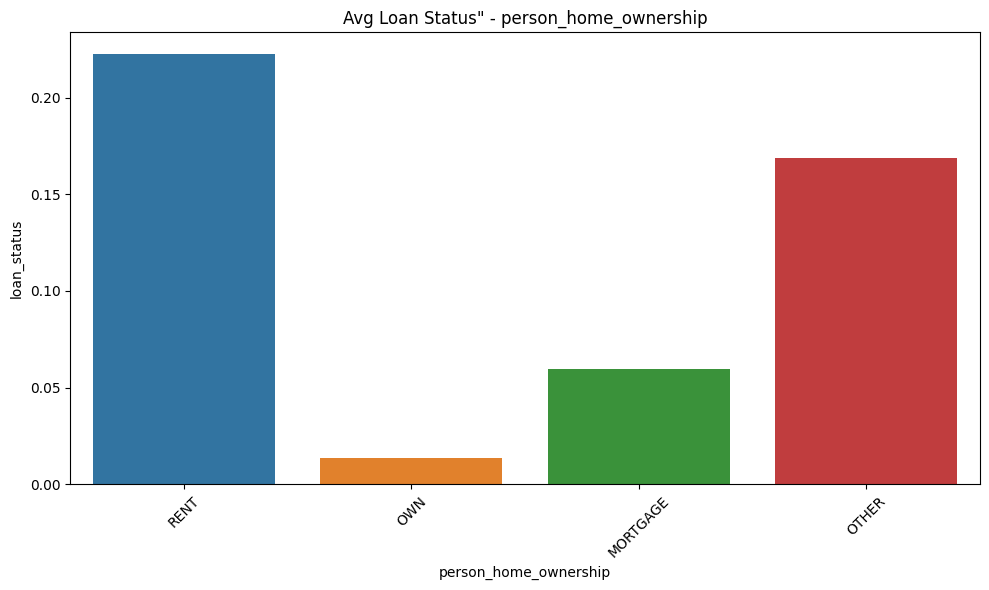

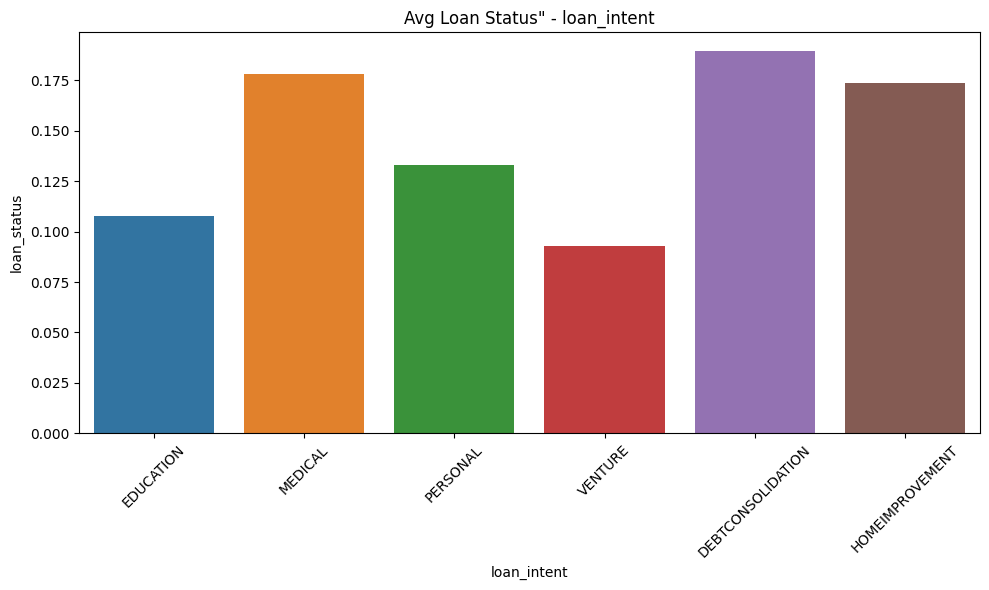

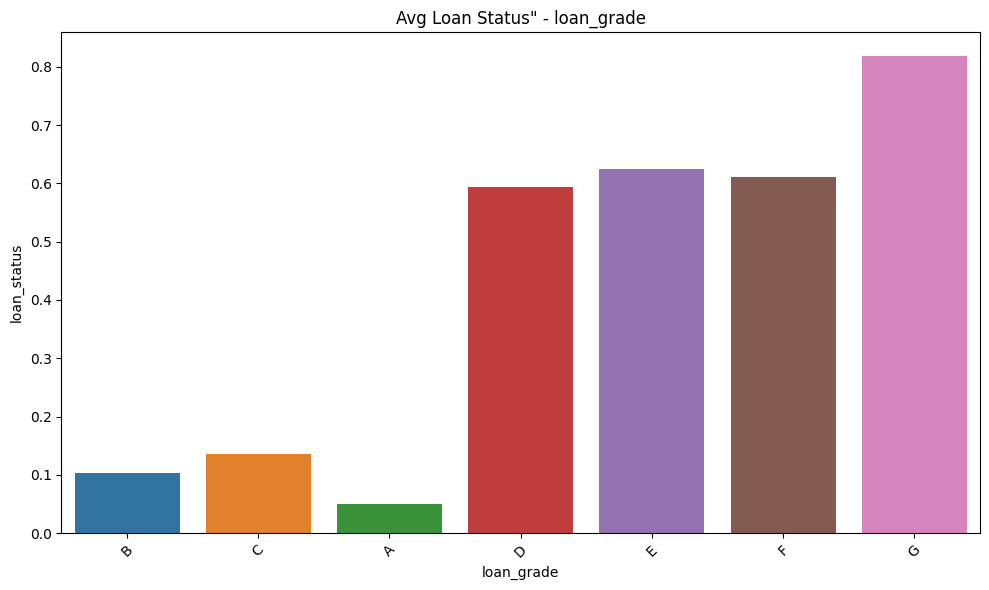

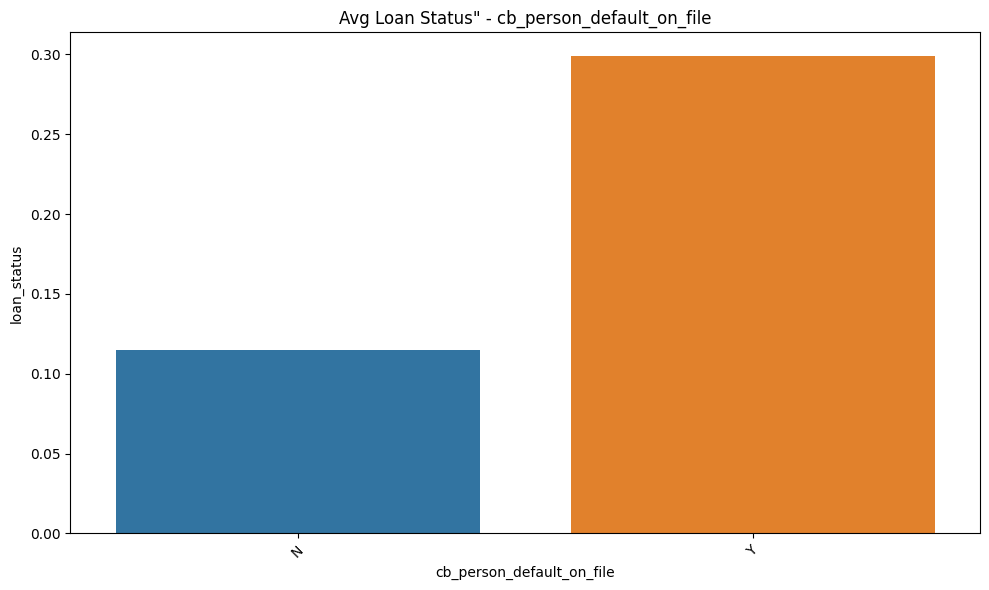

In [11]:
cat_cols = [col for col in train_s.columns if train_s[col].dtype == 'object']

for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.barplot(x=train_s[col], y=train_s["loan_status"], estimator='mean', ci=None)
    plt.title(f'Avg Loan Status" - {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

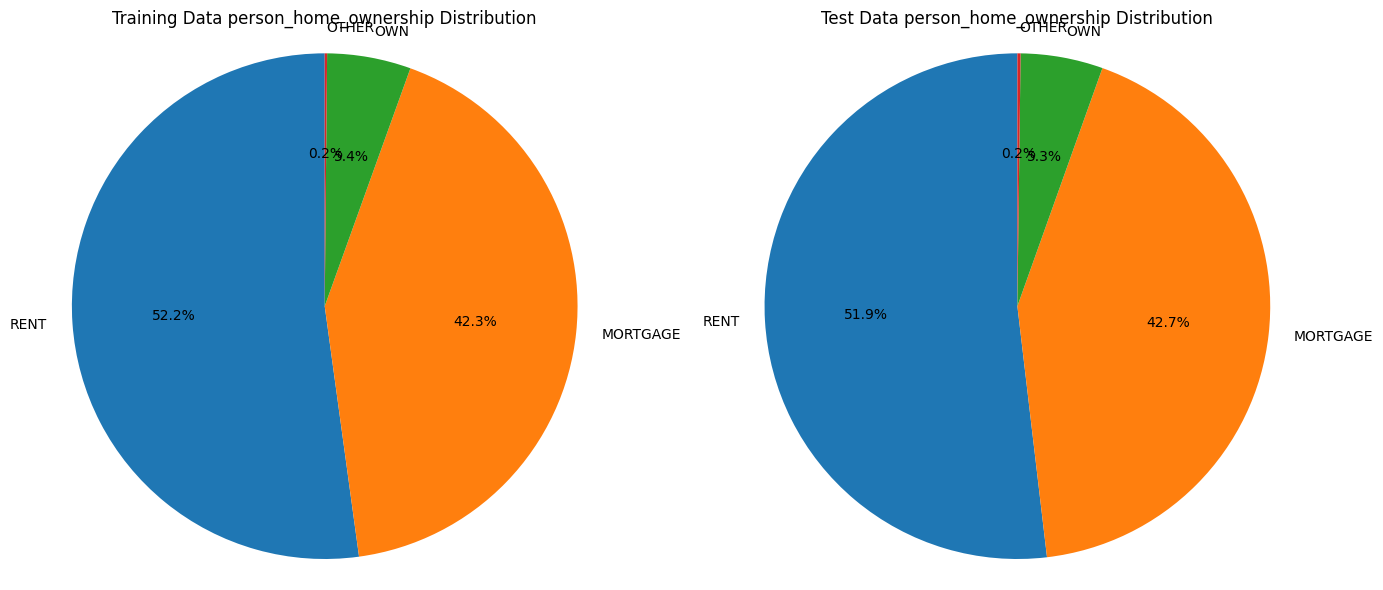

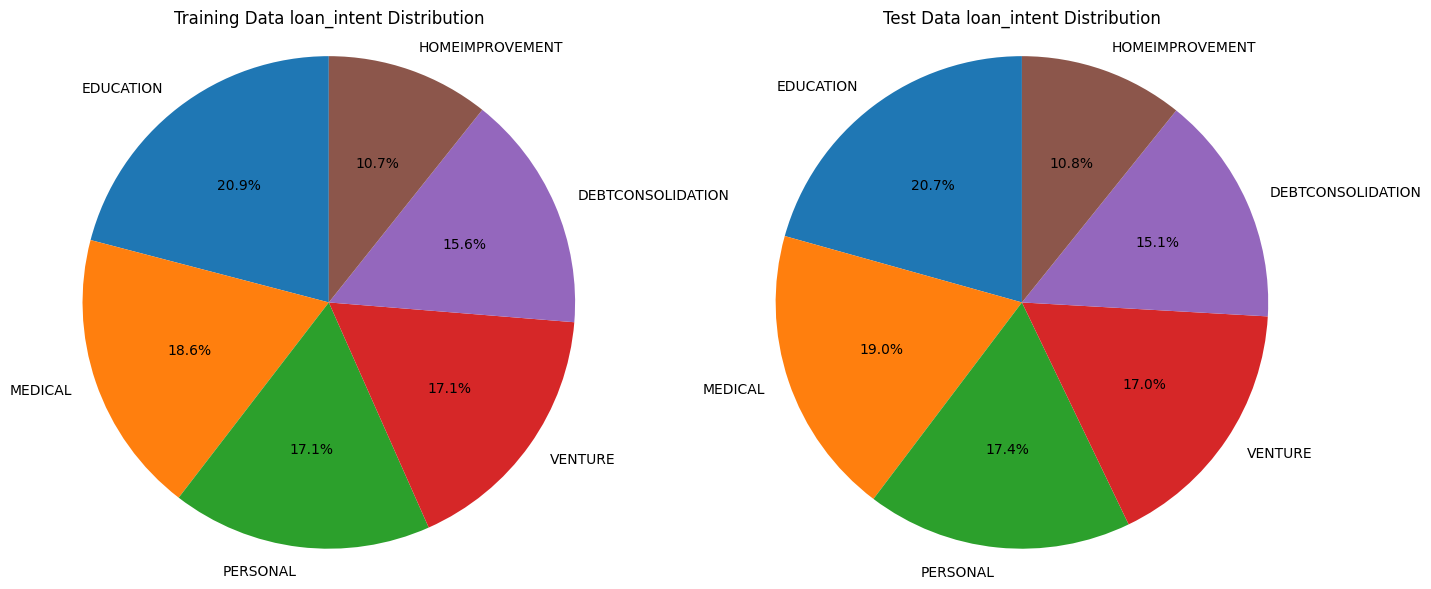

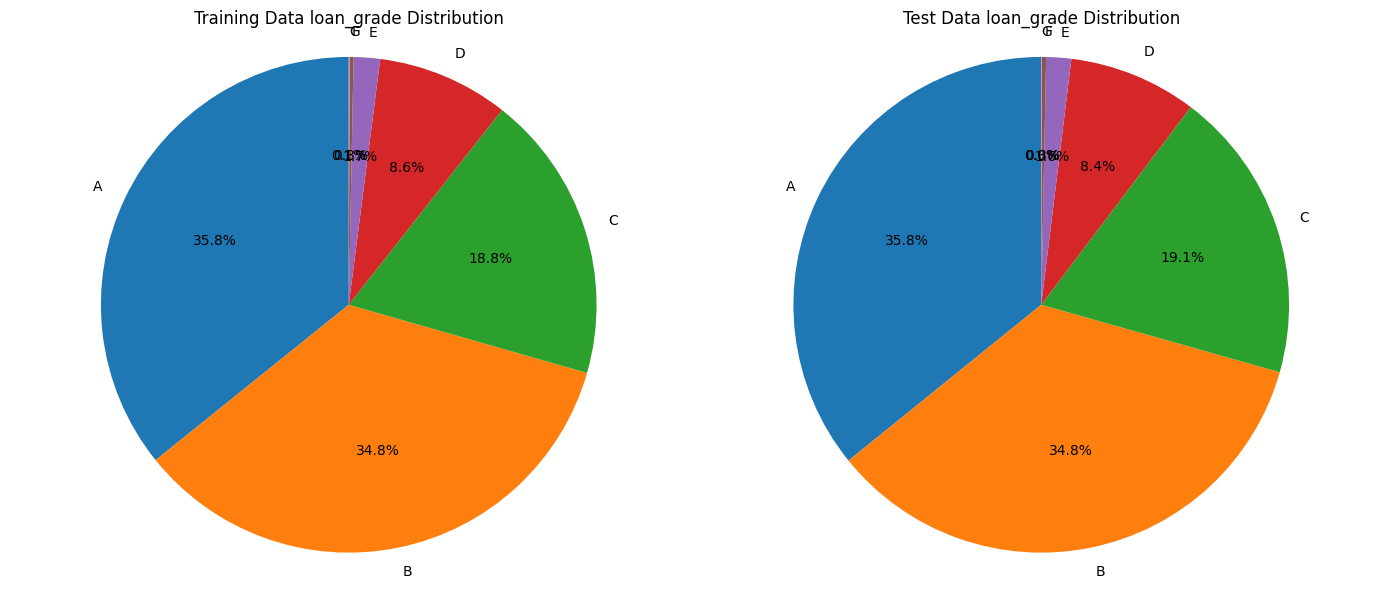

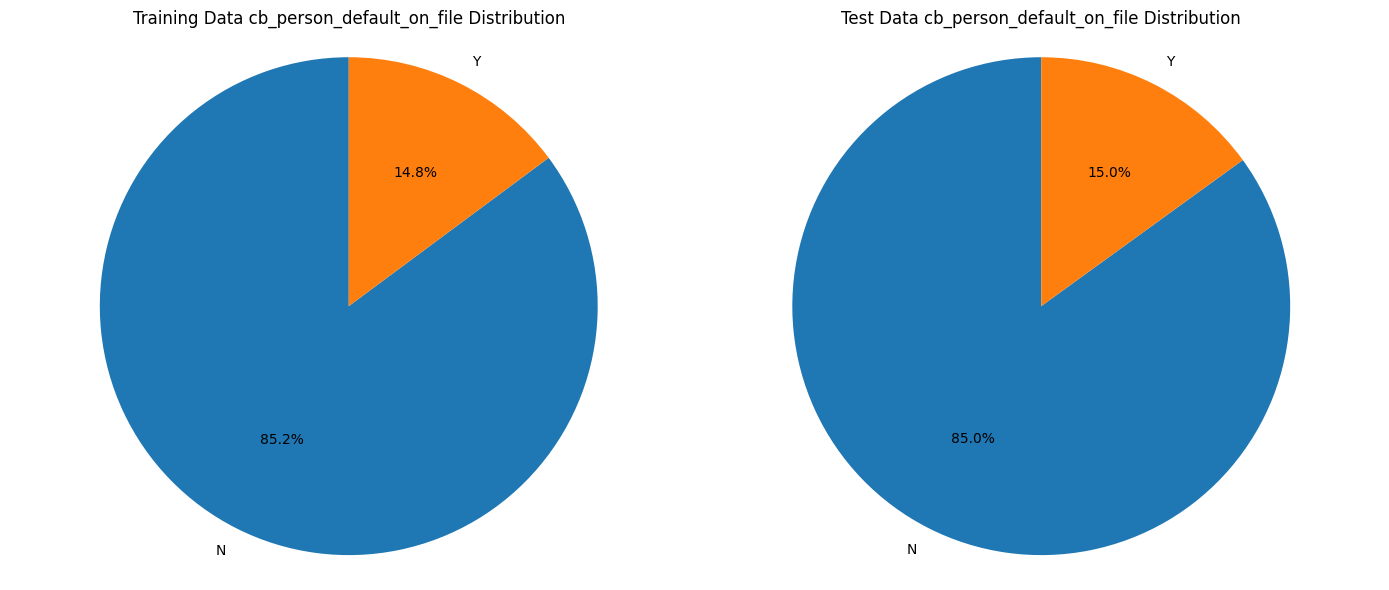

In [12]:
for col in cat_cols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    train_distribution = train_s[col].value_counts()
    axs[0].pie(train_distribution, labels=train_distribution.index, autopct='%1.1f%%', startangle=90)
    axs[0].set_title(f'Training Data {col} Distribution')
    axs[0].axis('equal')  
    
    test_distribution = test_s[col].value_counts()
    axs[1].pie(test_distribution, labels=test_distribution.index, autopct='%1.1f%%', startangle=90)
    axs[1].set_title(f'Test Data {col} Distribution')
    axs[1].axis('equal')  

    plt.tight_layout()
    plt.show()

#### Distributions of categorical columns seems same.

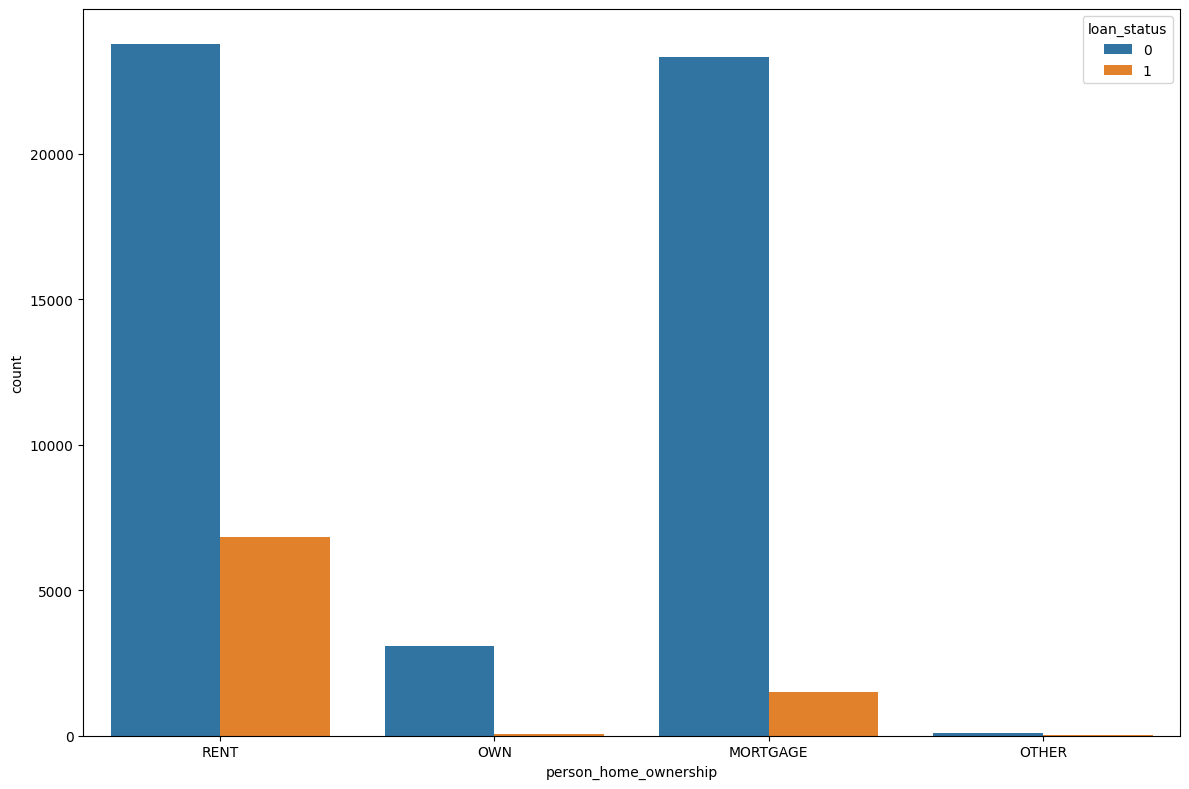

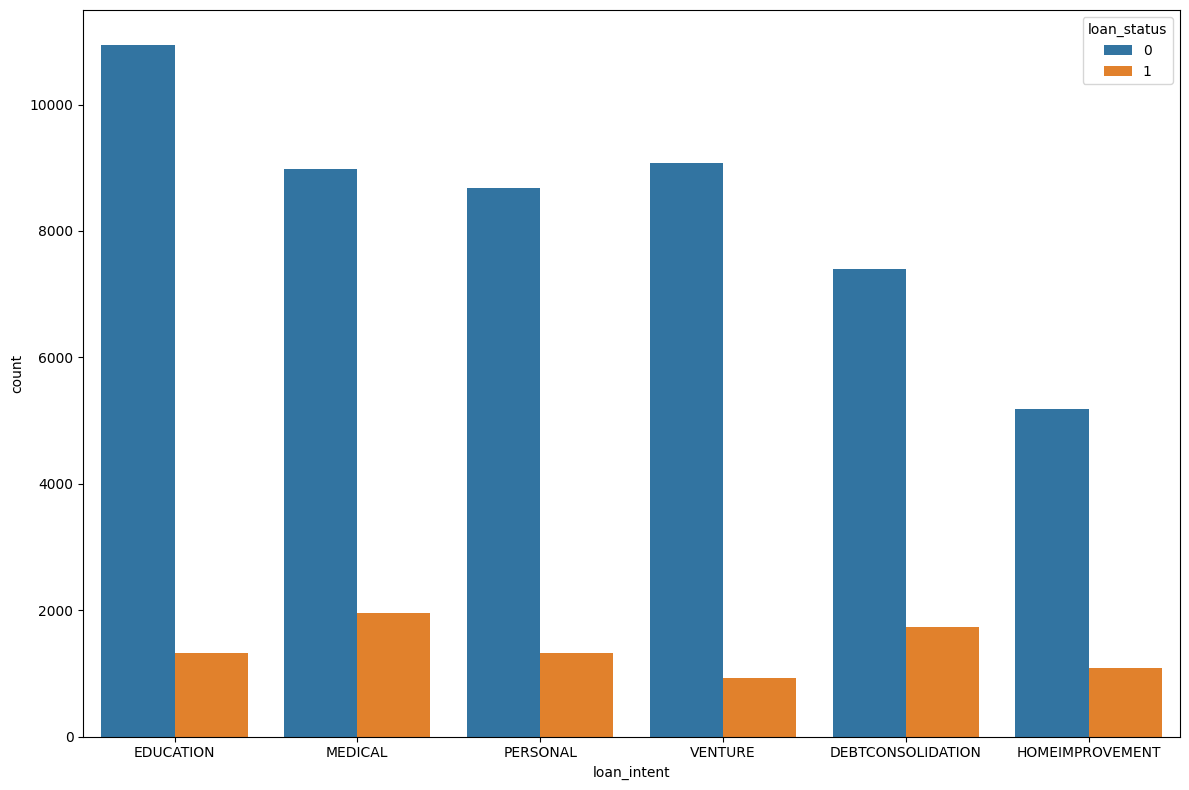

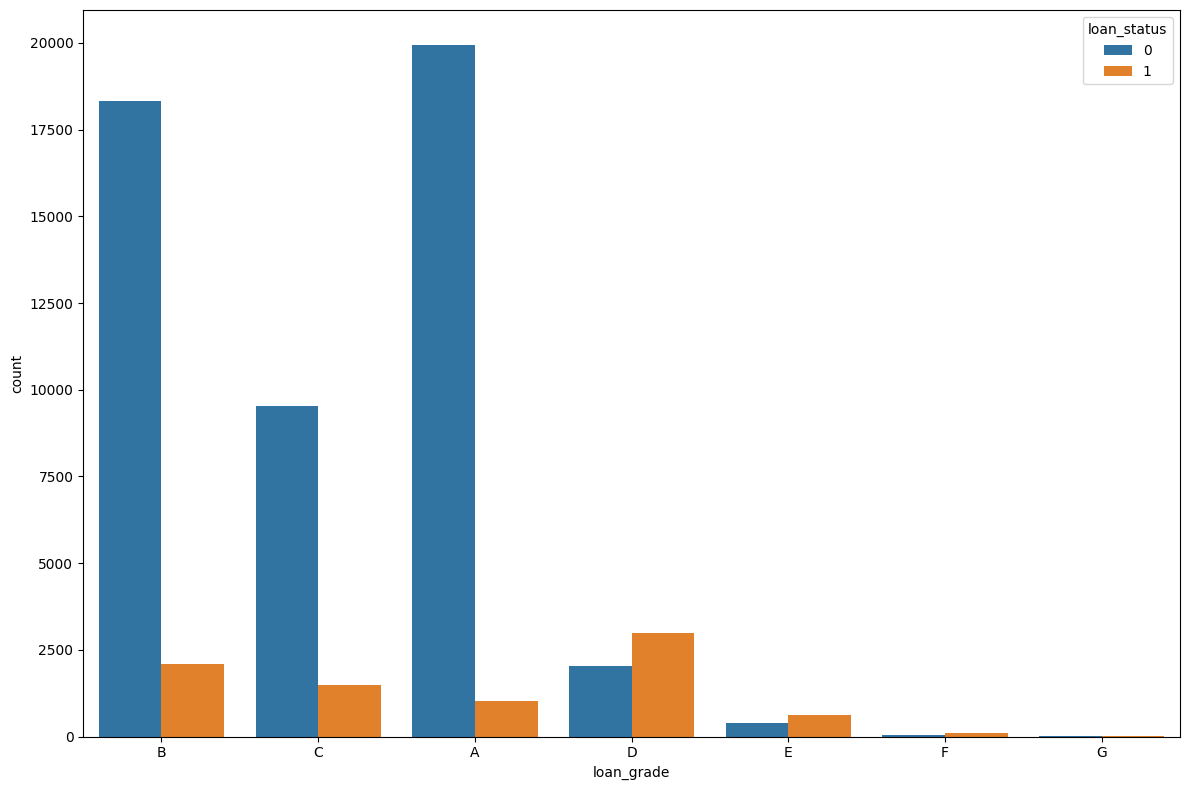

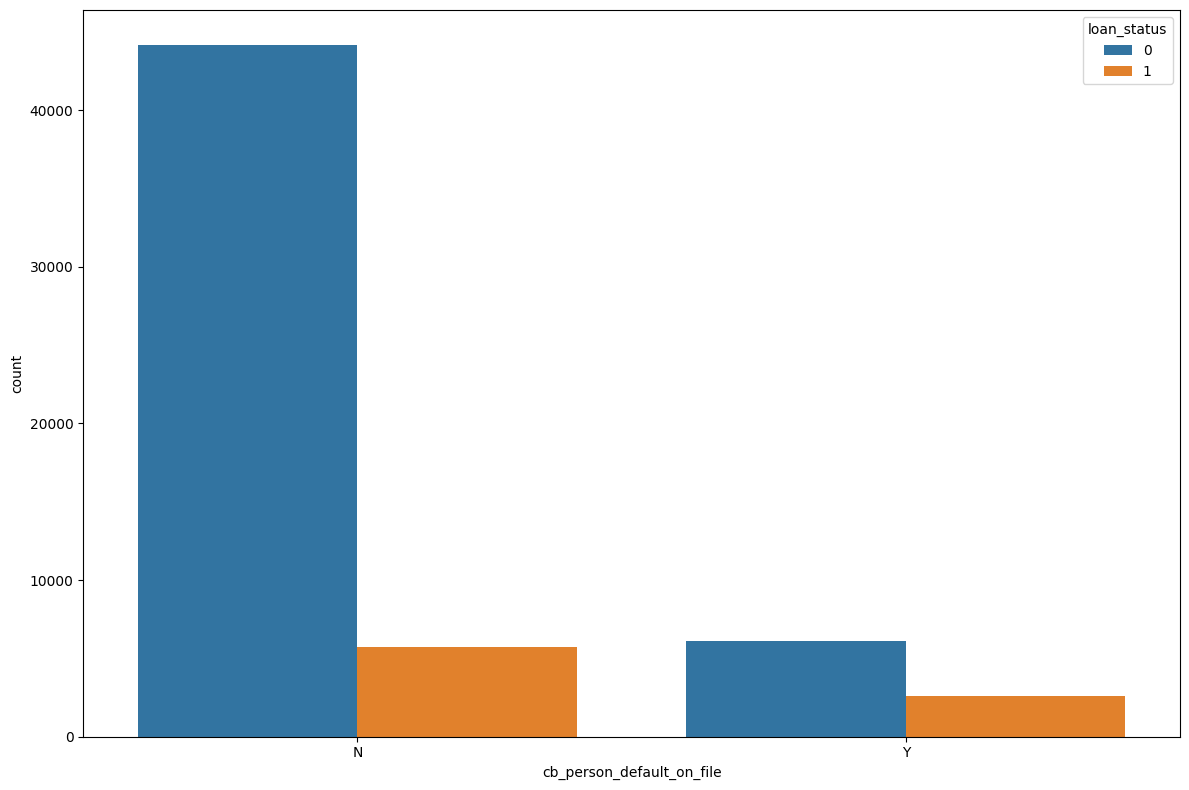

In [13]:
for i, col in enumerate(cat_cols):
    plt.figure(figsize=(12,8))
    sns.countplot(train_s, x=col, hue="loan_status")
    plt.tight_layout()
    plt.show()

Home ownership of 'RENT' and 'MORTGAGE' refers to a fixed debt

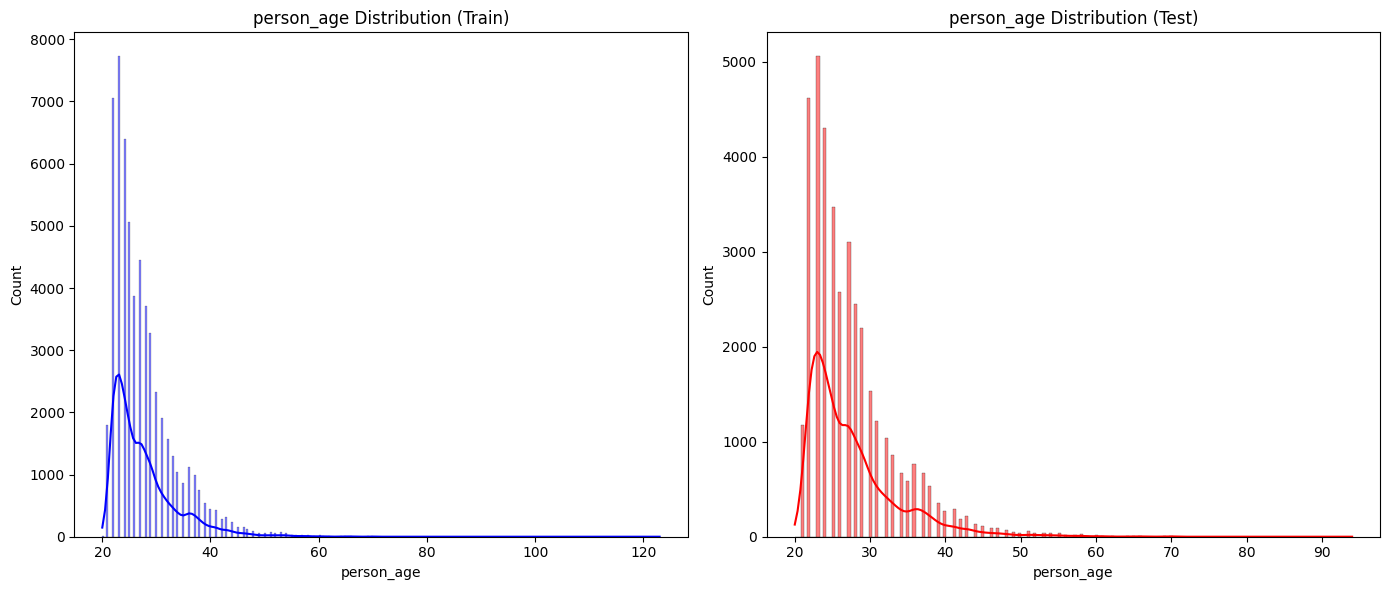

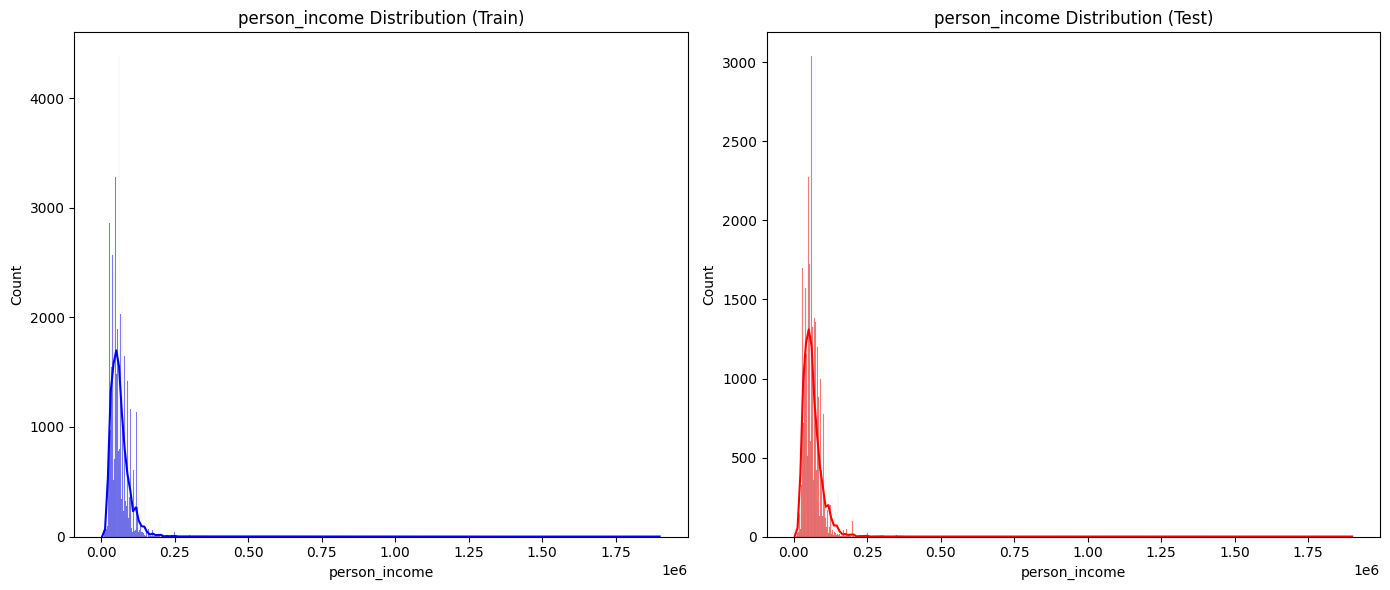

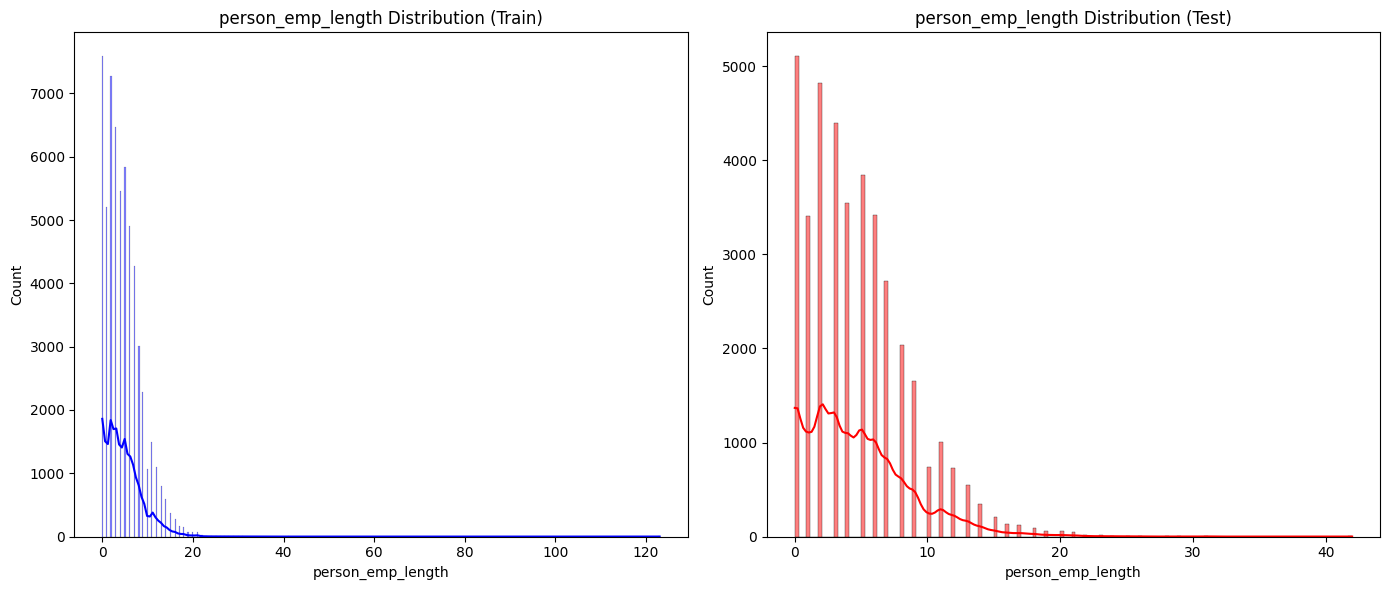

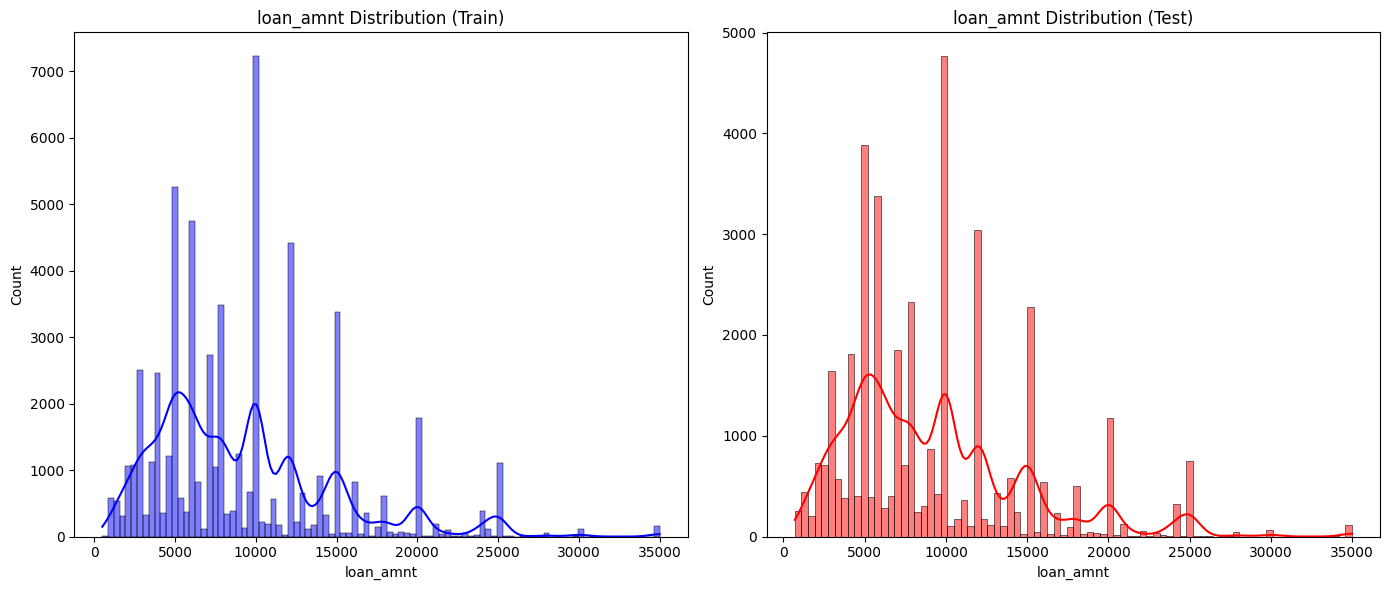

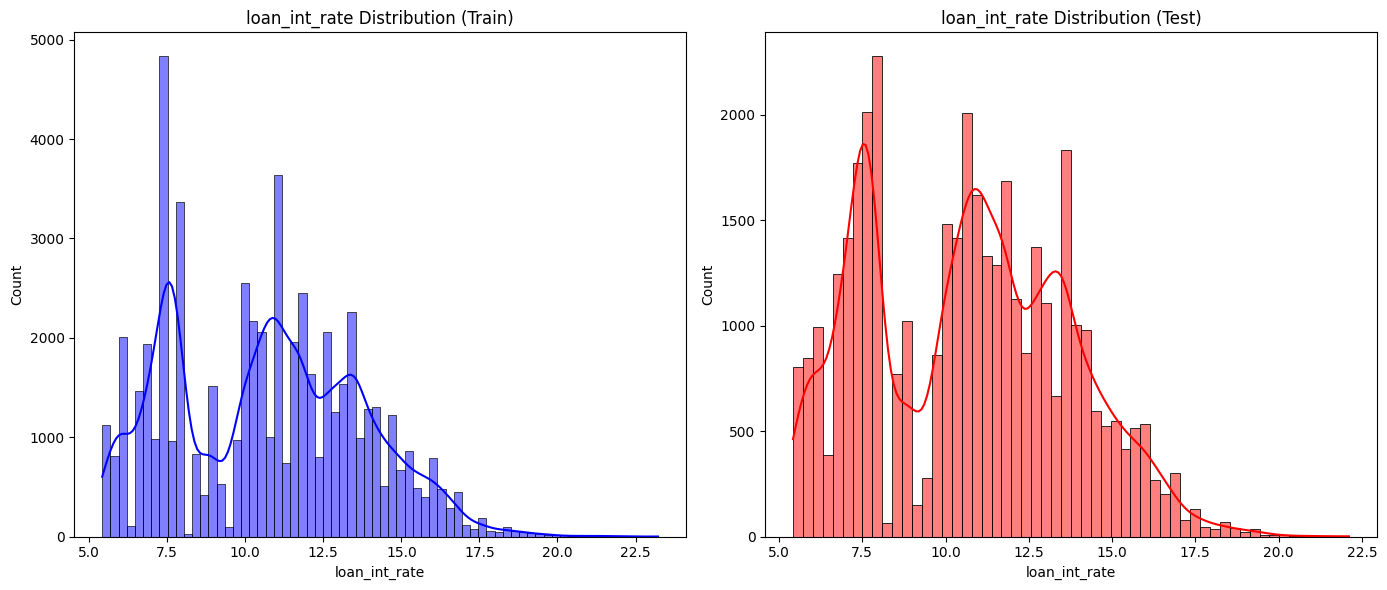

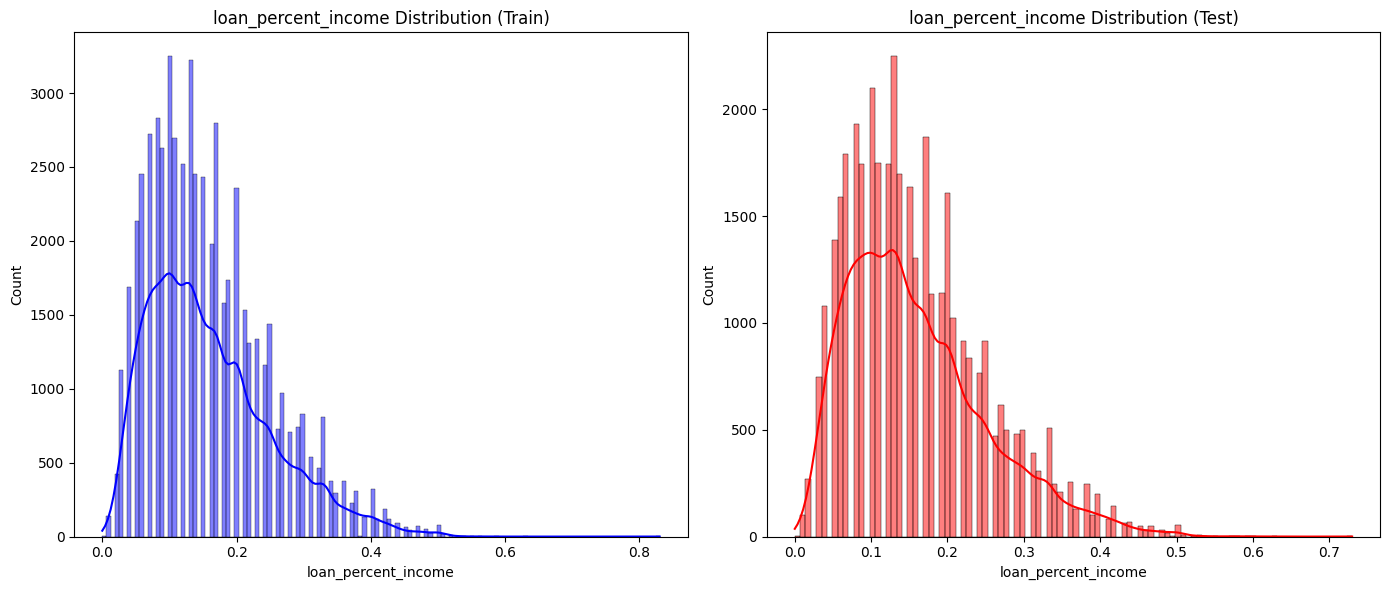

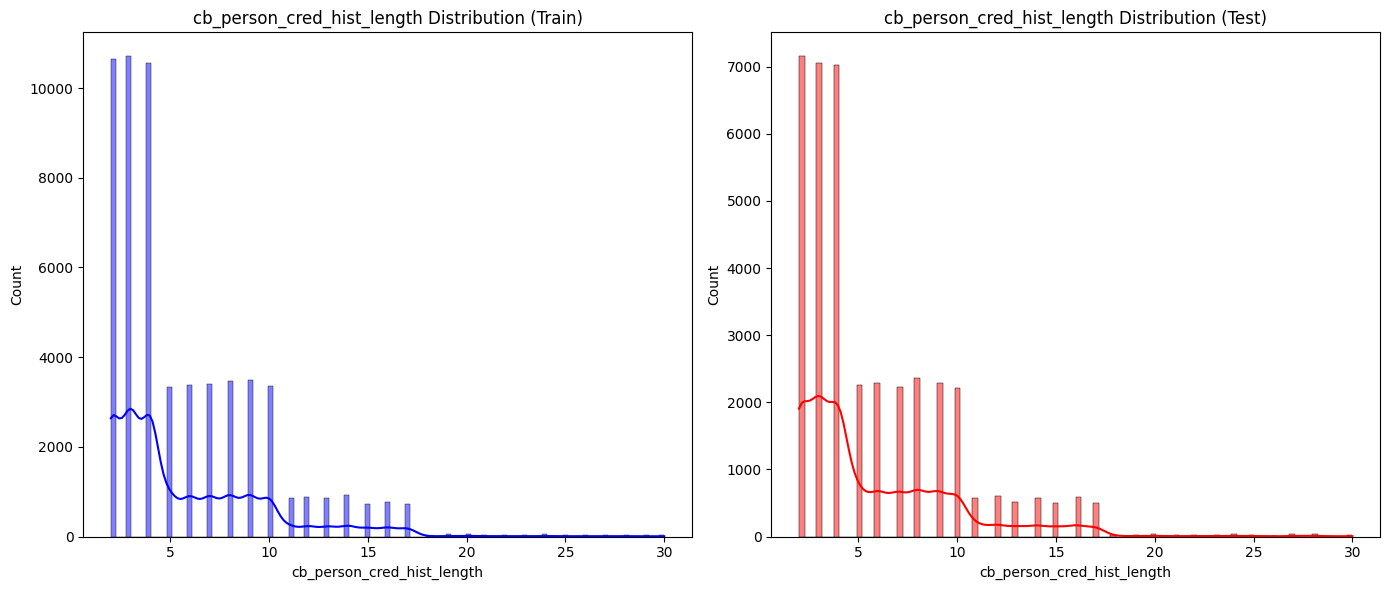

In [14]:
# Distributions of numeric columns
train_s = train_s.drop("label", axis=1)
num_cols = [col for col in train_s.columns if train_s[col].dtype != 'object']
drop_ones = ["id","loan_status"]
numeric_cols = [col for col in num_cols if col not in drop_ones]

for col in numeric_cols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sns.histplot(data=train_s, x=col, kde=True, ax=axs[0], color='blue')
    axs[0].set_title(f'{col} Distribution (Train)')
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Count')

    sns.histplot(data=test_s, x=col, kde=True, ax=axs[1], color='red')
    axs[1].set_title(f'{col} Distribution (Test)')
    axs[1].set_xlabel(col)
    axs[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()

### Distributions looks same. Some columns have high kurtosis and tailness. 

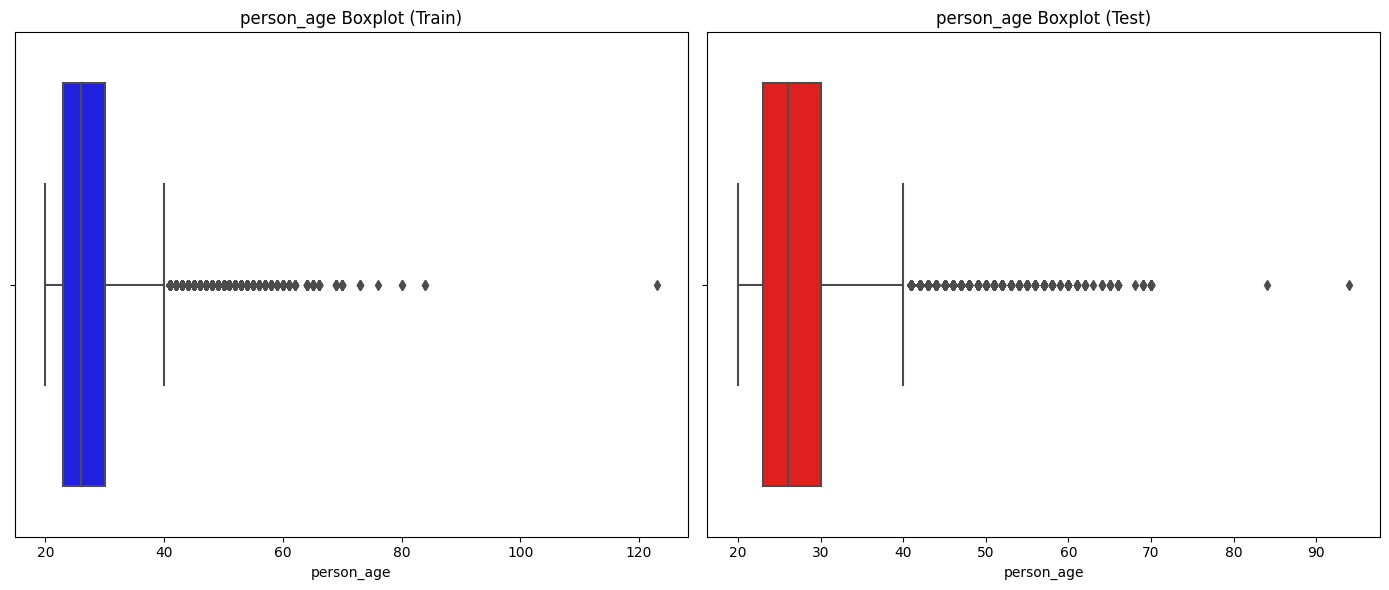

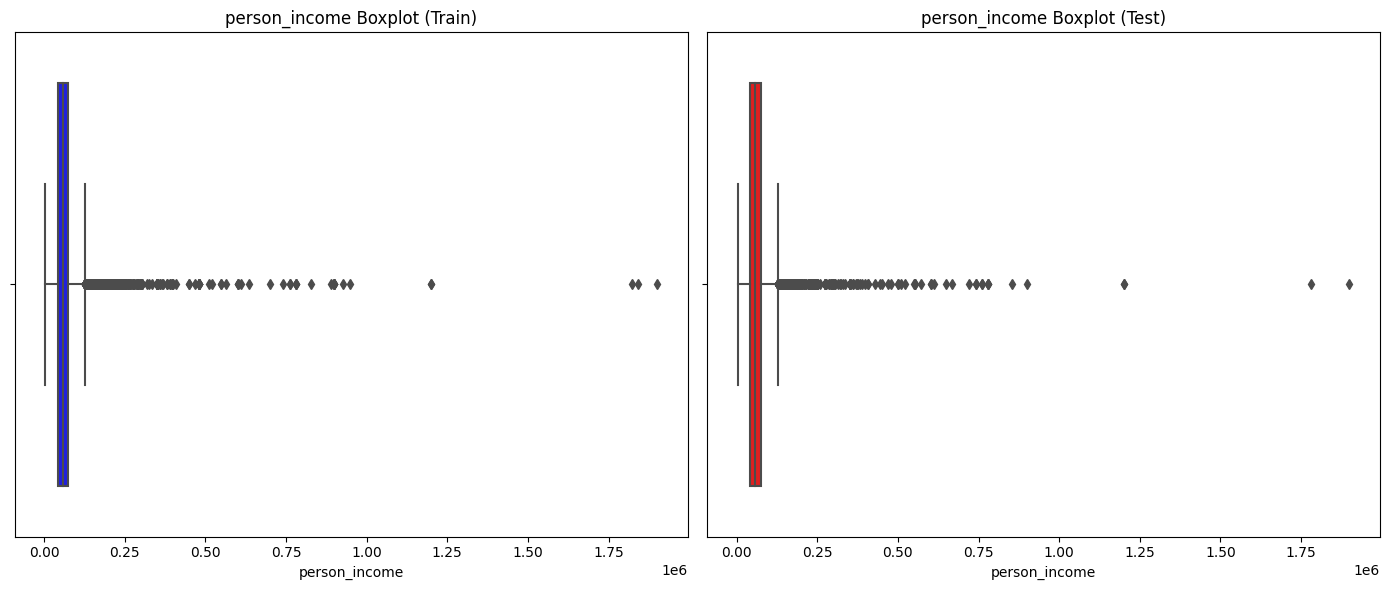

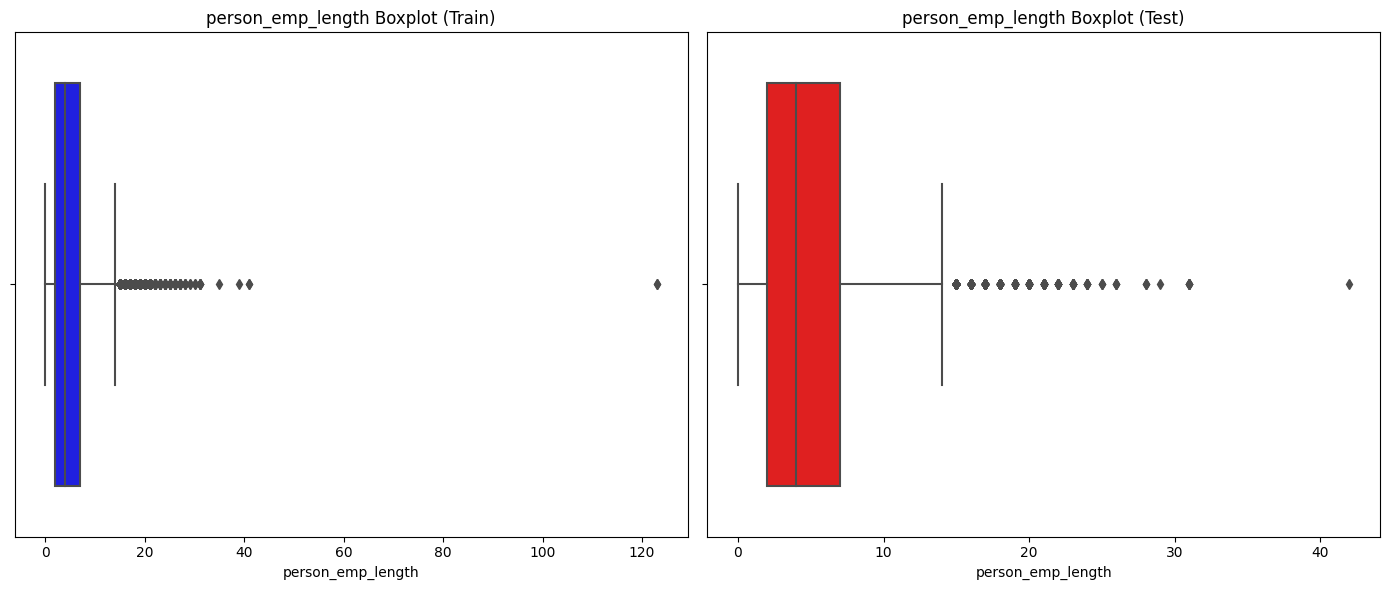

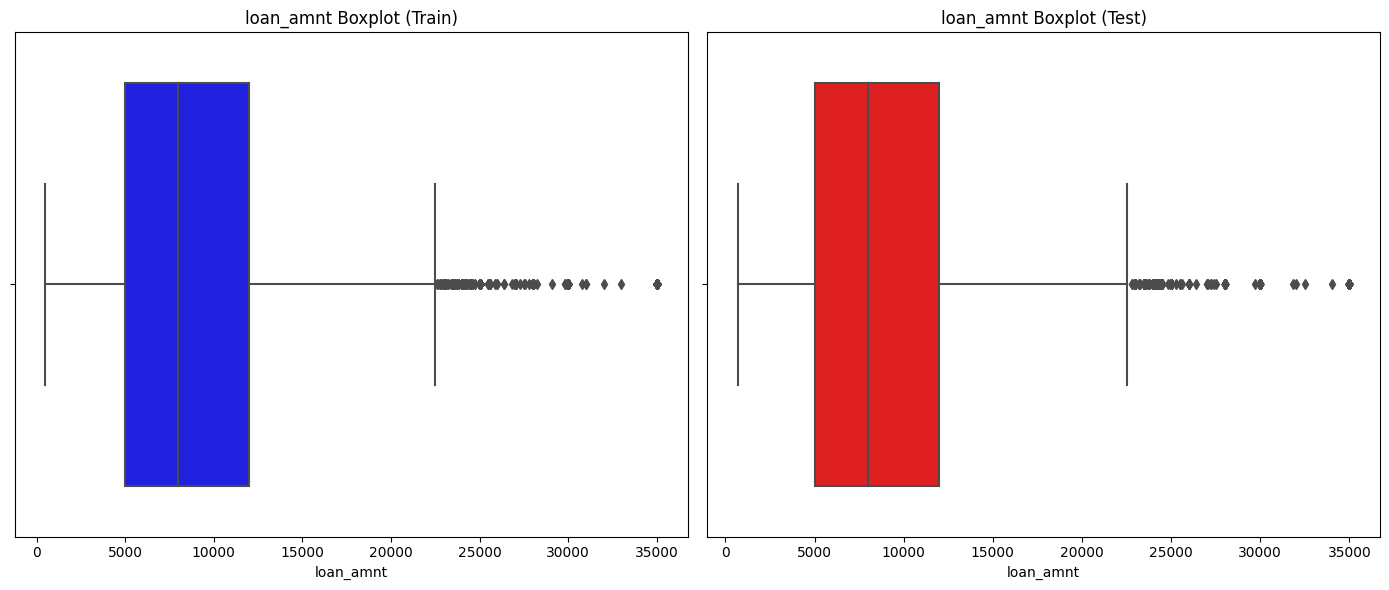

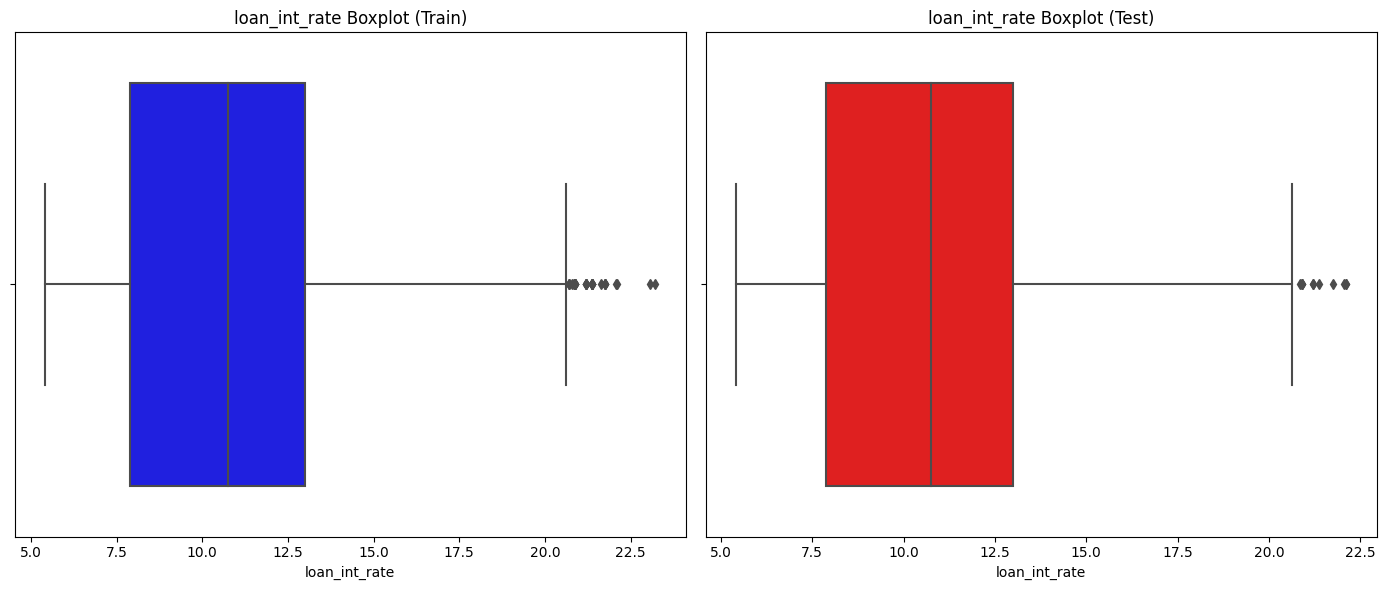

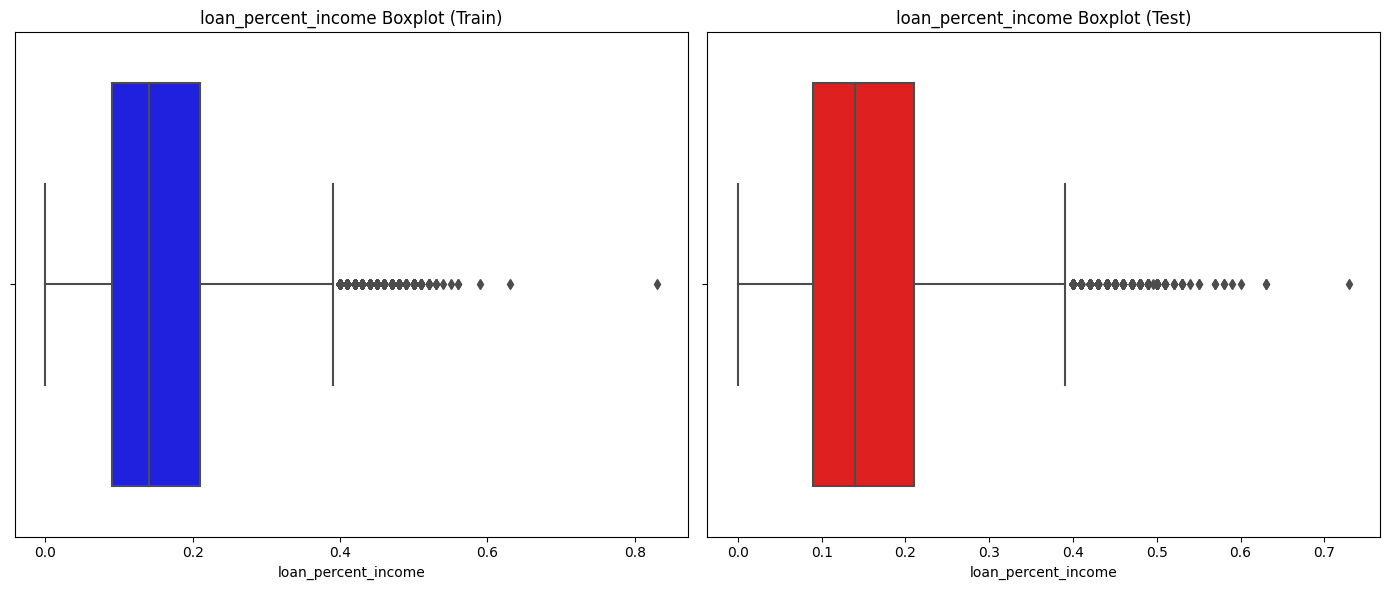

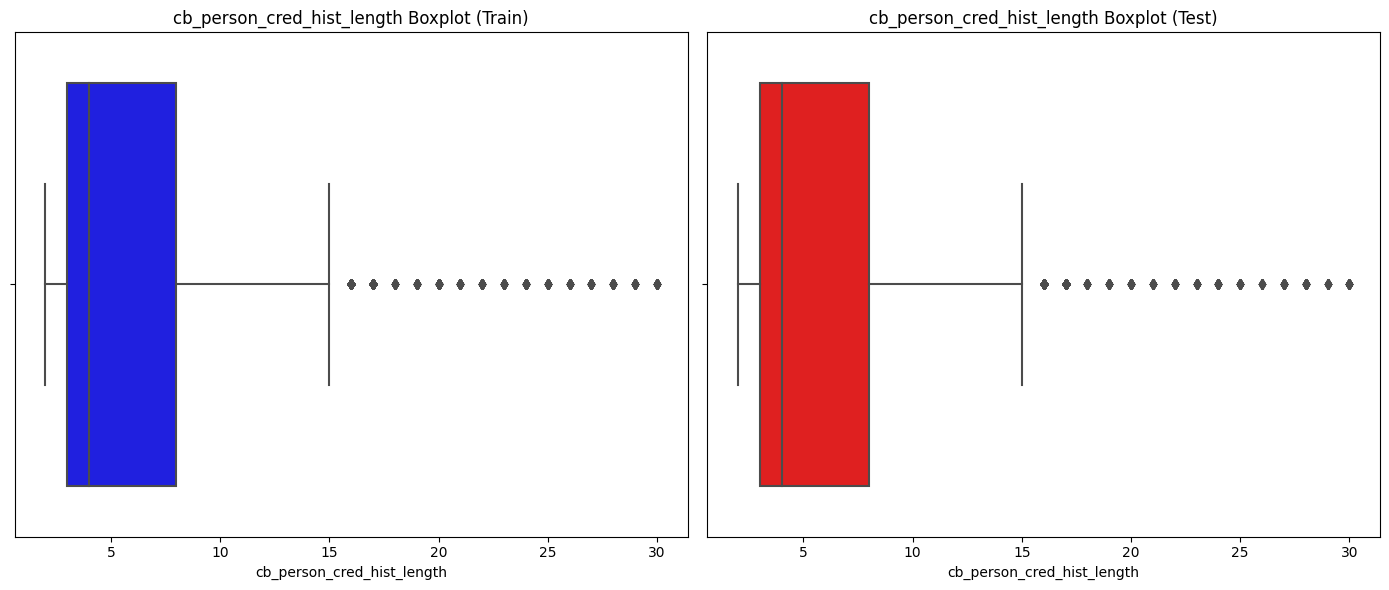

In [15]:
# Check for outliers as some colunms have tailness
for col in numeric_cols:
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sns.boxplot(data=train_s, x=col, ax=axs[0], color='blue')
    axs[0].set_title(f'{col} Boxplot (Train)')
    axs[0].set_xlabel(col)

    sns.boxplot(data=test_s, x=col, ax=axs[1], color='red')
    axs[1].set_title(f'{col} Boxplot (Test)')
    axs[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

#### Apart from the person who works for 120 years, will not handle outliers.

In [16]:
train_s.groupby("loan_grade")["loan_status"].mean().sort_values(ascending=False)

loan_grade
G    0.818182
E    0.625372
F    0.610738
D    0.593564
C    0.135375
B    0.102304
A    0.049180
Name: loan_status, dtype: float64

we maybe apply target encoding loan_grade

#### Correlation Map

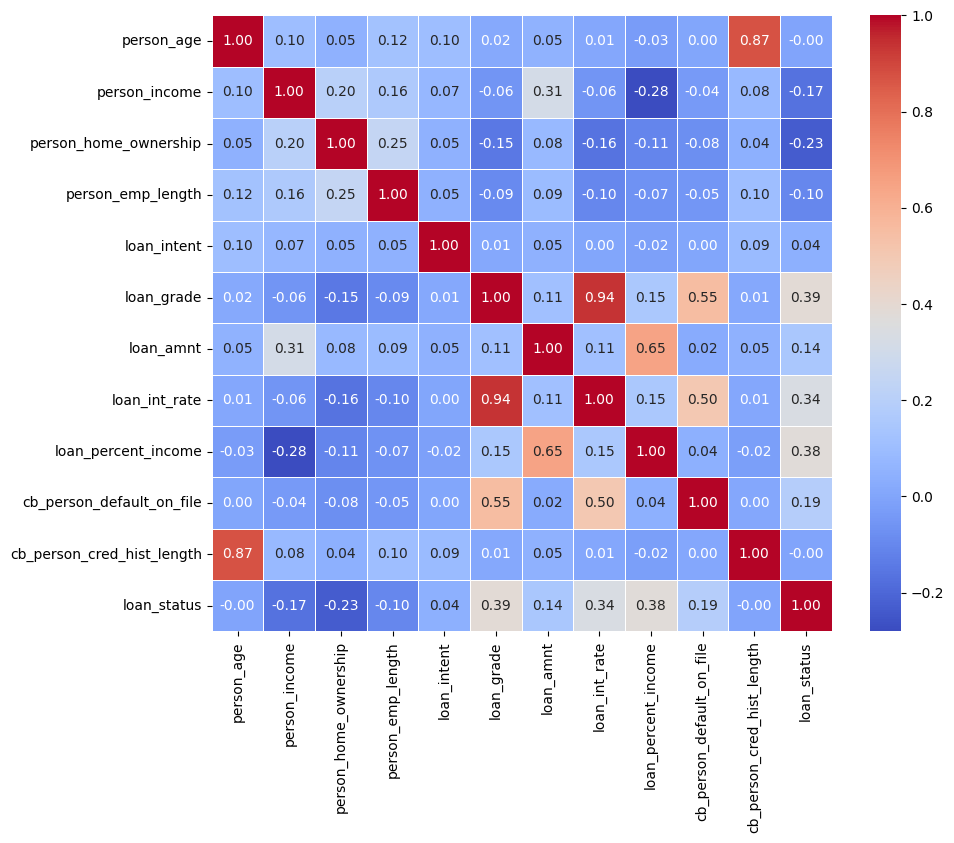

In [17]:
corr_df =  train_s.copy()

corr_df['person_home_ownership'].replace({'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}, inplace=True)
corr_df['loan_intent'].replace({'EDUCATION': 0, 'MEDICAL': 1, 'PERSONAL': 2, 'VENTURE': 3, 'DEBTCONSOLIDATION': 4, 'HOMEIMPROVEMENT': 5}, inplace=True)
corr_df['loan_grade'].replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}, inplace=True)
corr_df['cb_person_default_on_file'].replace({'N': 0, 'Y': 1}, inplace=True)

#corr_df["age_emp_length_interac"] = corr_df["person_age"] * corr_df["person_emp_length"]
#corr_df['home_emp_len_inter'] = corr_df['person_home_ownership'] * corr_df['person_emp_length']

corr_matrix = corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.show()

#### Mutual Information

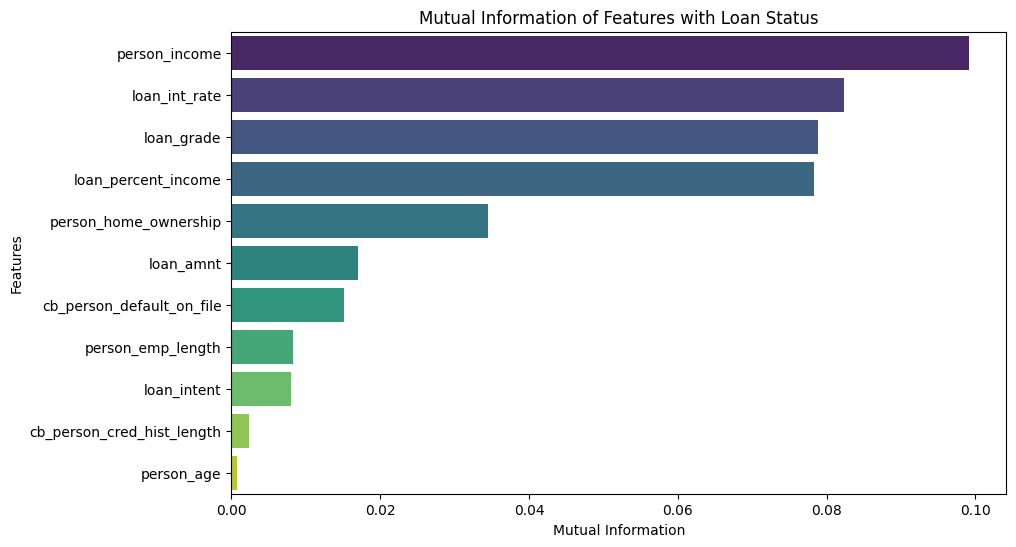

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif


X_train, X_test, y_train, y_test = train_test_split(corr_df.drop(labels=['loan_status'], axis=1),corr_df['loan_status'],test_size=0.3,random_state=42)

feature_names = X_train.columns

mutual_info = mutual_info_classif(X_train, y_train)

mutual_info_df = pd.Series(mutual_info, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=mutual_info_df.values, y=mutual_info_df.index, palette='viridis')

plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Mutual Information of Features with Loan Status')

plt.show()

## 4.Preprocess

In [19]:
train_ss = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
original = pd.read_csv('/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv')

columns_to_fill = ['person_emp_length', 'loan_int_rate']  
original[columns_to_fill] = original[columns_to_fill].fillna(original[columns_to_fill].mean())

train_s = pd.concat([train_s, original], ignore_index=True)
train_s = train_s.drop_duplicates()

In [20]:
# Person who works for more than 120 years
train_s = train_s[train_s['person_emp_length'] < 120]
# Person with more than 120 years old wtih 7 years employment
train_s = train_s[train_s['person_age'] < 120]

def calculate_monthly_payment(row, loan_term_years):
    loan_amnt = row['loan_amnt']
    loan_int_rate = row['loan_int_rate']
    monthly_rate = loan_int_rate / 12 / 100
    n = loan_term_years * 12
    monthly_payment = loan_amnt * monthly_rate * (1 + monthly_rate) ** n / ((1 + monthly_rate) ** n - 1)
    
    return monthly_payment

loan_term_years = 1

train_s['monthly_payment'] = train_s.apply(calculate_monthly_payment, loan_term_years=loan_term_years, axis=1)
train_s['monthly_payment'] = train_s['monthly_payment'].astype('int')
train_s['monthly_income'] = train_s['person_income'] / 12
train_s['monthly_income'] = train_s['monthly_income'].astype('int')
train_s["monthly_dti_ratio"] = train_s["monthly_payment"] / train_s["monthly_income"]
train_s = train_s.drop(columns=["monthly_payment", "monthly_income"])


train_s["risky"] = (np.where((train_s['cb_person_default_on_file'] == 'Y') & (train_s['loan_grade'].isin(['D','E','F','G'])), 1, 0))
train_s["has_fixed_debt"] = np.where(train_s["person_home_ownership"].isin(['RENT', 'MORTGAGE']), 1, 0)

train_s["person_emp_length"] = train_s["person_emp_length"].astype('int')

In [21]:
test_s['monthly_payment'] = test_s.apply(calculate_monthly_payment, loan_term_years=loan_term_years, axis=1)
test_s['monthly_payment'] = test_s['monthly_payment'].astype('int')
test_s['monthly_income'] = test_s['person_income'] / 12
test_s['monthly_income'] = test_s['monthly_income'].astype('int')
test_s["monthly_dti_ratio"] = test_s["monthly_payment"] / test_s["monthly_income"]
test_s = test_s.drop(columns=["monthly_payment", "monthly_income"])


test_s["risky"] = (np.where((test_s['cb_person_default_on_file'] == 'Y') & (test_s['loan_grade'].isin(['D','E','F','G'])), 1, 0))
test_s["has_fixed_debt"] = np.where(test_s["person_home_ownership"].isin(['RENT', 'MORTGAGE']), 1, 0)

test_s["person_emp_length"] = test_s["person_emp_length"].astype('int')

In [22]:
features = test_s.columns.tolist()

def convert_category(df):
    df_c = df.copy()
    for col in features:
        if df_c[col].dtype == 'object':
            df_c[col] = df_c[col].astype('category')
        else:
            df_c[col] = df_c[col].astype('string').astype('category')
    return df_c

train_cat = convert_category(train_s)
test_cat = convert_category(test_s)

print(train_cat.dtypes)

person_age                    category
person_income                 category
person_home_ownership         category
person_emp_length             category
loan_intent                   category
loan_grade                    category
loan_amnt                     category
loan_int_rate                 category
loan_percent_income           category
cb_person_default_on_file     category
cb_person_cred_hist_length    category
loan_status                      int64
monthly_dti_ratio             category
risky                         category
has_fixed_debt                category
dtype: object


In [23]:
def convert_category_lgbm(df):
    df_l = df.copy()
    for col in features:
        if df_l[col].dtype == 'object':
            df_l[col] = df_l[col].astype('category')
    return df_l

train_lgb = convert_category_lgbm(train_s)
test_lgb = convert_category_lgbm(test_s)

print(train_lgb.dtypes)

person_age                       int64
person_income                    int64
person_home_ownership         category
person_emp_length                int64
loan_intent                   category
loan_grade                    category
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file     category
cb_person_cred_hist_length       int64
loan_status                      int64
monthly_dti_ratio              float64
risky                            int64
has_fixed_debt                   int64
dtype: object


## 5.Model

In [24]:
X = train_cat[features]
y = train_cat["loan_status"]

cat_features = np.where(X.dtypes != np.float64)[0]

folds = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
test_preds_clf = np.empty((10, len(test_cat)))
auc_vals=[]

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    train_pool = Pool(X_train, y_train,cat_features=cat_features)
    val_pool = Pool(X_val, y_val,cat_features=cat_features)
    
    clf = CatBoostClassifier(
    eval_metric='AUC',
    task_type='GPU',
    learning_rate=0.02,
    iterations=6000)
    
    clf.fit(train_pool, eval_set=val_pool,verbose=300)
    
    y_pred_val = clf.predict_proba(X_val[features])[:,1]
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ",n_fold + 1,": ",auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test = clf.predict_proba(test_cat[features])[:,1]
    test_preds_clf[n_fold, :] = y_pred_test
    print("----------------")

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8801490	best: 0.8801490 (0)	total: 2.71s	remaining: 4h 30m 57s
300:	test: 0.9643825	best: 0.9643825 (300)	total: 10.1s	remaining: 3m 11s
600:	test: 0.9664868	best: 0.9664868 (600)	total: 17.7s	remaining: 2m 38s
900:	test: 0.9671596	best: 0.9671596 (900)	total: 25.1s	remaining: 2m 22s
1200:	test: 0.9675943	best: 0.9675943 (1200)	total: 32.5s	remaining: 2m 9s
1500:	test: 0.9679319	best: 0.9679344 (1495)	total: 39.8s	remaining: 1m 59s
1800:	test: 0.9681658	best: 0.9681658 (1800)	total: 47.2s	remaining: 1m 50s
2100:	test: 0.9683144	best: 0.9683144 (2100)	total: 54.6s	remaining: 1m 41s
2400:	test: 0.9684575	best: 0.9684575 (2400)	total: 1m 1s	remaining: 1m 32s
2700:	test: 0.9684482	best: 0.9684995 (2600)	total: 1m 9s	remaining: 1m 24s
3000:	test: 0.9685292	best: 0.9685382 (2985)	total: 1m 16s	remaining: 1m 16s
3300:	test: 0.9685382	best: 0.9685590 (3115)	total: 1m 24s	remaining: 1m 8s
3600:	test: 0.9686040	best: 0.9686243 (3505)	total: 1m 31s	remaining: 1m
3900:	test: 0.9685625	b

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8876363	best: 0.8876363 (0)	total: 26.3ms	remaining: 2m 37s
300:	test: 0.9623666	best: 0.9623666 (300)	total: 7.34s	remaining: 2m 18s
600:	test: 0.9644865	best: 0.9644865 (600)	total: 14.8s	remaining: 2m 12s
900:	test: 0.9654886	best: 0.9654886 (900)	total: 22.1s	remaining: 2m 5s
1200:	test: 0.9661369	best: 0.9661369 (1200)	total: 29.5s	remaining: 1m 57s
1500:	test: 0.9666076	best: 0.9666177 (1490)	total: 36.9s	remaining: 1m 50s
1800:	test: 0.9670194	best: 0.9670194 (1800)	total: 44.2s	remaining: 1m 43s
2100:	test: 0.9672245	best: 0.9672295 (2095)	total: 51.4s	remaining: 1m 35s
2400:	test: 0.9674468	best: 0.9674574 (2390)	total: 58.7s	remaining: 1m 28s
2700:	test: 0.9675425	best: 0.9675634 (2680)	total: 1m 6s	remaining: 1m 20s
3000:	test: 0.9676239	best: 0.9676372 (2980)	total: 1m 13s	remaining: 1m 13s
3300:	test: 0.9676750	best: 0.9677060 (3275)	total: 1m 20s	remaining: 1m 6s
3600:	test: 0.9677794	best: 0.9677794 (3600)	total: 1m 28s	remaining: 58.8s
3900:	test: 0.9678674	b

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8834384	best: 0.8834384 (0)	total: 25.8ms	remaining: 2m 34s
300:	test: 0.9624093	best: 0.9624093 (300)	total: 7.43s	remaining: 2m 20s
600:	test: 0.9647264	best: 0.9647264 (600)	total: 14.9s	remaining: 2m 14s
900:	test: 0.9656500	best: 0.9656500 (900)	total: 22.4s	remaining: 2m 7s
1200:	test: 0.9663605	best: 0.9663605 (1200)	total: 29.9s	remaining: 1m 59s
1500:	test: 0.9669130	best: 0.9669130 (1500)	total: 37.2s	remaining: 1m 51s
1800:	test: 0.9673322	best: 0.9673322 (1800)	total: 44.5s	remaining: 1m 43s
2100:	test: 0.9675274	best: 0.9675353 (2090)	total: 52s	remaining: 1m 36s
2400:	test: 0.9678075	best: 0.9678075 (2400)	total: 59.3s	remaining: 1m 28s
2700:	test: 0.9680479	best: 0.9680479 (2700)	total: 1m 6s	remaining: 1m 21s
3000:	test: 0.9683162	best: 0.9683226 (2995)	total: 1m 13s	remaining: 1m 13s
3300:	test: 0.9684304	best: 0.9684304 (3300)	total: 1m 21s	remaining: 1m 6s
3600:	test: 0.9686204	best: 0.9686212 (3595)	total: 1m 28s	remaining: 59.2s
3900:	test: 0.9687864	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8845753	best: 0.8845753 (0)	total: 25.7ms	remaining: 2m 33s
300:	test: 0.9638689	best: 0.9638689 (300)	total: 7.37s	remaining: 2m 19s
600:	test: 0.9660002	best: 0.9660002 (600)	total: 14.8s	remaining: 2m 13s
900:	test: 0.9667702	best: 0.9667702 (900)	total: 22.3s	remaining: 2m 5s
1200:	test: 0.9672544	best: 0.9672544 (1200)	total: 29.7s	remaining: 1m 58s
1500:	test: 0.9675349	best: 0.9675349 (1500)	total: 37s	remaining: 1m 51s
1800:	test: 0.9677652	best: 0.9677652 (1800)	total: 44.4s	remaining: 1m 43s
2100:	test: 0.9680192	best: 0.9680242 (2070)	total: 51.8s	remaining: 1m 36s
2400:	test: 0.9680363	best: 0.9680437 (2345)	total: 59.2s	remaining: 1m 28s
2700:	test: 0.9681242	best: 0.9681242 (2700)	total: 1m 6s	remaining: 1m 21s
3000:	test: 0.9681503	best: 0.9681585 (2990)	total: 1m 13s	remaining: 1m 13s
3300:	test: 0.9681458	best: 0.9681585 (2990)	total: 1m 21s	remaining: 1m 6s
3600:	test: 0.9681677	best: 0.9681732 (3590)	total: 1m 28s	remaining: 59s
3900:	test: 0.9681285	best:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8842103	best: 0.8842103 (0)	total: 27.5ms	remaining: 2m 45s
300:	test: 0.9620557	best: 0.9620557 (300)	total: 7.39s	remaining: 2m 19s
600:	test: 0.9646495	best: 0.9646495 (600)	total: 14.8s	remaining: 2m 13s
900:	test: 0.9656636	best: 0.9656636 (900)	total: 22.2s	remaining: 2m 5s
1200:	test: 0.9662844	best: 0.9662844 (1200)	total: 29.6s	remaining: 1m 58s
1500:	test: 0.9667634	best: 0.9667719 (1490)	total: 36.9s	remaining: 1m 50s
1800:	test: 0.9670780	best: 0.9670780 (1800)	total: 44.4s	remaining: 1m 43s
2100:	test: 0.9673126	best: 0.9673126 (2100)	total: 51.8s	remaining: 1m 36s
2400:	test: 0.9674805	best: 0.9674805 (2400)	total: 59.1s	remaining: 1m 28s
2700:	test: 0.9675997	best: 0.9675997 (2700)	total: 1m 6s	remaining: 1m 21s
3000:	test: 0.9676583	best: 0.9676920 (2905)	total: 1m 13s	remaining: 1m 13s
3300:	test: 0.9676388	best: 0.9676920 (2905)	total: 1m 21s	remaining: 1m 6s
3600:	test: 0.9677364	best: 0.9677458 (3570)	total: 1m 28s	remaining: 58.9s
3900:	test: 0.9677439	b

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8790018	best: 0.8790018 (0)	total: 26ms	remaining: 2m 36s
300:	test: 0.9591278	best: 0.9591278 (300)	total: 7.32s	remaining: 2m 18s
600:	test: 0.9615647	best: 0.9615647 (600)	total: 14.8s	remaining: 2m 13s
900:	test: 0.9625453	best: 0.9625453 (900)	total: 22.2s	remaining: 2m 5s
1200:	test: 0.9633334	best: 0.9633334 (1200)	total: 29.6s	remaining: 1m 58s
1500:	test: 0.9638626	best: 0.9638626 (1500)	total: 36.9s	remaining: 1m 50s
1800:	test: 0.9642414	best: 0.9642487 (1795)	total: 44.3s	remaining: 1m 43s
2100:	test: 0.9646378	best: 0.9646378 (2100)	total: 51.9s	remaining: 1m 36s
2400:	test: 0.9649469	best: 0.9649469 (2400)	total: 59.3s	remaining: 1m 28s
2700:	test: 0.9651907	best: 0.9651907 (2700)	total: 1m 6s	remaining: 1m 21s
3000:	test: 0.9653341	best: 0.9653583 (2965)	total: 1m 14s	remaining: 1m 14s
3300:	test: 0.9655352	best: 0.9655365 (3295)	total: 1m 21s	remaining: 1m 6s
3600:	test: 0.9657055	best: 0.9657055 (3600)	total: 1m 28s	remaining: 59.3s
3900:	test: 0.9657982	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8835556	best: 0.8835556 (0)	total: 27.3ms	remaining: 2m 43s
300:	test: 0.9587646	best: 0.9587646 (300)	total: 7.55s	remaining: 2m 23s
600:	test: 0.9608284	best: 0.9608284 (600)	total: 15s	remaining: 2m 15s
900:	test: 0.9616810	best: 0.9616810 (900)	total: 22.4s	remaining: 2m 6s
1200:	test: 0.9622446	best: 0.9622474 (1195)	total: 29.7s	remaining: 1m 58s
1500:	test: 0.9626079	best: 0.9626102 (1495)	total: 37s	remaining: 1m 50s
1800:	test: 0.9629656	best: 0.9629656 (1800)	total: 44.5s	remaining: 1m 43s
2100:	test: 0.9631449	best: 0.9631449 (2100)	total: 52s	remaining: 1m 36s
2400:	test: 0.9632782	best: 0.9632782 (2400)	total: 59.6s	remaining: 1m 29s
2700:	test: 0.9634870	best: 0.9634870 (2700)	total: 1m 7s	remaining: 1m 22s
3000:	test: 0.9635695	best: 0.9635820 (2975)	total: 1m 14s	remaining: 1m 14s
3300:	test: 0.9636447	best: 0.9636810 (3255)	total: 1m 22s	remaining: 1m 7s
3600:	test: 0.9636639	best: 0.9637057 (3545)	total: 1m 29s	remaining: 59.9s
3900:	test: 0.9637267	best: 0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8790361	best: 0.8790361 (0)	total: 27ms	remaining: 2m 42s
300:	test: 0.9609189	best: 0.9609189 (300)	total: 7.42s	remaining: 2m 20s
600:	test: 0.9631599	best: 0.9631599 (600)	total: 14.8s	remaining: 2m 13s
900:	test: 0.9642023	best: 0.9642023 (900)	total: 22.2s	remaining: 2m 5s
1200:	test: 0.9648954	best: 0.9648954 (1200)	total: 29.7s	remaining: 1m 58s
1500:	test: 0.9653796	best: 0.9653796 (1500)	total: 37.1s	remaining: 1m 51s
1800:	test: 0.9657167	best: 0.9657167 (1800)	total: 44.3s	remaining: 1m 43s
2100:	test: 0.9660140	best: 0.9660140 (2100)	total: 51.7s	remaining: 1m 35s
2400:	test: 0.9661213	best: 0.9661281 (2370)	total: 59.1s	remaining: 1m 28s
2700:	test: 0.9661891	best: 0.9662042 (2675)	total: 1m 6s	remaining: 1m 21s
3000:	test: 0.9662428	best: 0.9662522 (2985)	total: 1m 13s	remaining: 1m 13s
3300:	test: 0.9663766	best: 0.9663766 (3300)	total: 1m 21s	remaining: 1m 6s
3600:	test: 0.9664932	best: 0.9665019 (3570)	total: 1m 28s	remaining: 59s
3900:	test: 0.9665720	best:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8917968	best: 0.8917968 (0)	total: 26.3ms	remaining: 2m 37s
300:	test: 0.9670249	best: 0.9670249 (300)	total: 7.48s	remaining: 2m 21s
600:	test: 0.9690702	best: 0.9690702 (600)	total: 15.2s	remaining: 2m 16s
900:	test: 0.9698800	best: 0.9698800 (900)	total: 22.7s	remaining: 2m 8s
1200:	test: 0.9703505	best: 0.9703505 (1200)	total: 30s	remaining: 1m 59s
1500:	test: 0.9706300	best: 0.9706300 (1500)	total: 37.4s	remaining: 1m 52s
1800:	test: 0.9708926	best: 0.9708939 (1790)	total: 44.8s	remaining: 1m 44s
2100:	test: 0.9710500	best: 0.9710560 (2095)	total: 52.1s	remaining: 1m 36s
2400:	test: 0.9712702	best: 0.9712732 (2395)	total: 59.4s	remaining: 1m 28s
2700:	test: 0.9714103	best: 0.9714103 (2700)	total: 1m 6s	remaining: 1m 21s
3000:	test: 0.9714919	best: 0.9714974 (2950)	total: 1m 14s	remaining: 1m 14s
3300:	test: 0.9714614	best: 0.9715034 (3095)	total: 1m 21s	remaining: 1m 6s
3600:	test: 0.9714378	best: 0.9715034 (3095)	total: 1m 28s	remaining: 59.2s
3900:	test: 0.9714730	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.8646245	best: 0.8646245 (0)	total: 26.3ms	remaining: 2m 37s
300:	test: 0.9537174	best: 0.9537174 (300)	total: 7.42s	remaining: 2m 20s
600:	test: 0.9563799	best: 0.9563799 (600)	total: 14.9s	remaining: 2m 13s
900:	test: 0.9576156	best: 0.9576156 (900)	total: 22.3s	remaining: 2m 6s
1200:	test: 0.9583973	best: 0.9583973 (1200)	total: 29.6s	remaining: 1m 58s
1500:	test: 0.9588946	best: 0.9588968 (1495)	total: 36.9s	remaining: 1m 50s
1800:	test: 0.9593762	best: 0.9593785 (1790)	total: 44.3s	remaining: 1m 43s
2100:	test: 0.9596892	best: 0.9596892 (2100)	total: 51.7s	remaining: 1m 35s
2400:	test: 0.9599937	best: 0.9599937 (2400)	total: 59s	remaining: 1m 28s
2700:	test: 0.9602991	best: 0.9602991 (2700)	total: 1m 6s	remaining: 1m 20s
3000:	test: 0.9605569	best: 0.9605578 (2960)	total: 1m 13s	remaining: 1m 13s
3300:	test: 0.9608024	best: 0.9608024 (3300)	total: 1m 21s	remaining: 1m 6s
3600:	test: 0.9610453	best: 0.9610459 (3595)	total: 1m 28s	remaining: 59s
3900:	test: 0.9613171	best:

In [25]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.9672947890623096)

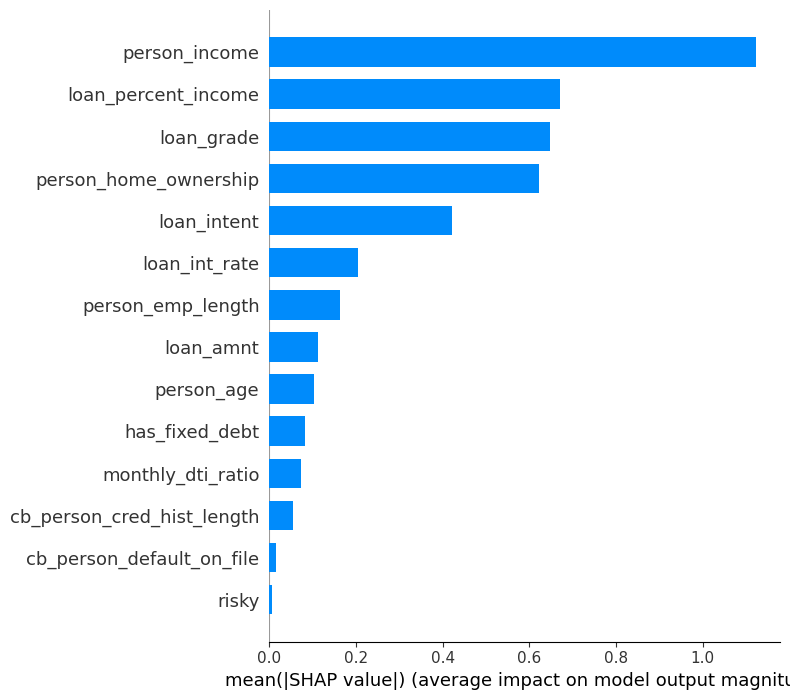

In [26]:
explainer = shap.Explainer(clf)
shap_values = explainer(X_val)  

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_val, plot_type="bar")
plt.show()

In [27]:
X = train_lgb[features]
y = train_lgb["loan_status"]

folds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
test_preds_lgb = np.empty((10, len(test_cat)))
auc_vals = []
models = []
cat_features = X.select_dtypes(include='category').columns.tolist()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    
    dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    dvalid = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_features, reference=dtrain)
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': 0,
        'max_depth' : 7,
        'num_leaves': 25,
        "num_iterations":6000,
        'learning_rate': 0.02,
        'device' : 'gpu'
    }
    
    log_evaluation = lgb.log_evaluation(period=200)
    
    clf_lgb = lgb.train(params,dtrain,num_boost_round=1500,valid_sets=[dtrain, dvalid],valid_names=['train', 'valid'],categorical_feature=cat_features,callbacks = [log_evaluation])
    
    y_pred_val = clf_lgb.predict(X_val[features])
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ", n_fold + 1, ": ", auc_val)
    auc_vals.append(auc_val)
    
    y_pred_test_lgb = clf_lgb.predict(test_lgb[features])
    test_preds_lgb[n_fold, :] = y_pred_test_lgb
    print("----------------")

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[200]	train's auc: 0.947159	valid's auc: 0.949507
[400]	train's auc: 0.959635	valid's auc: 0.958496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	train's auc: 0.965685	valid's auc: 0.960965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [28]:
"Mean AUC: ",np.mean(auc_vals)

('Mean AUC: ', 0.9593324008310073)

In [29]:
import xgboost as xgb

X = train_lgb[features]
y = train_lgb["loan_status"]

folds = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
test_preds_xgb = np.empty((10, len(test_cat))) 
auc_vals = []


cat_features = X.select_dtypes(include='category').columns.tolist()

for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[valid_idx], y.iloc[valid_idx]
    

    params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss',         
    'eta': 0.1,                      
    'max_depth': 6,                   
    'min_child_weight': 1,            
    'subsample': 0.8,                 
    'colsample_bytree': 0.8,         
    'n_estimators': 5000,              
    'seed': 42,
    'enable_categorical': True
}
    
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(X_train[features], y_train) 
    

    y_pred_val = xgb_model.predict_proba(X_val[features])[:, 1] 
    auc_val = roc_auc_score(y_val, y_pred_val)
    print("AUC for fold ", n_fold + 1, ": ", auc_val)
    auc_vals.append(auc_val)
    
    # Predict on test set
    y_pred_test_xgb = xgb_model.predict_proba(test_lgb[features])[:, 1]  
    test_preds_xgb[n_fold, :] = y_pred_test_xgb
    print("----------------")

print("Average AUC: ", np.mean(auc_vals))

AUC for fold  1 :  0.9525543503582816
----------------
AUC for fold  2 :  0.9474212999712209
----------------
AUC for fold  3 :  0.9509708295202518
----------------
AUC for fold  4 :  0.9532749191261077
----------------
AUC for fold  5 :  0.9458077326860704
----------------
AUC for fold  6 :  0.949775418992882
----------------
AUC for fold  7 :  0.9455219739555243
----------------
AUC for fold  8 :  0.9516831754579164
----------------
AUC for fold  9 :  0.9562284181917982
----------------
AUC for fold  10 :  0.9487747494814198
----------------
Average AUC:  0.9502012867741474


## 6.Submission

In [30]:
sample_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
sample_sub["loan_status"] = (y_pred_test * 0.4) + (y_pred_test_lgb * 0.3) + (y_pred_test_xgb * 0.3)
sample_sub.to_csv('baseline_sub_3m__.csv', index=False)
sample_sub.head()

,id,loan_status
0,58645,0.999968
1,58646,0.014081
2,58647,0.723441
3,58648,0.004280
4,58649,0.022887
